In [1]:
import scanpy as sc
import numpy as np
from scipy.spatial import cKDTree
from alpha_shapes import Alpha_Shaper, plot_alpha_shape
import pandas as pd

In [2]:
import os
import re
def load_results(data_dir,pattern):
    slices = []
    files = []
    for filename in os.listdir(data_dir):
        if pattern in filename :
            files.append(filename)
    files.sort(key=lambda x: int(re.search(r'_(\d+)\.h5ad', x).group(1)))
   
    for filename in files:
        file_path = os.path.join(data_dir, filename)
        adata = sc.read_h5ad(file_path)
        slices.append(adata)
 
    return slices

In [3]:
PASTE_DLPFCS=load_results('/SABench/AlignmentResults/PASTE_DLPFCS/','.h5ad')
PASTE_p0_DLPFCS=load_results('/SABench/AlignmentResults/PASTE_p0_DLPFCS/','.h5ad')
PASTE2_DLPFCS=load_results('/SABench/AlignmentResults/PASTE2_DLPFCS/','.h5ad')
STAligner_DLPFCS_landmark0=load_results('/SABench/AlignmentResults/STAligner_DLPFCS/','landmark0')
STAligner_DLPFCS_landmark1=load_results('/SABench/AlignmentResults/STAligner_DLPFCS/','landmark1')
STAligner_DLPFCS_landmark2=load_results('/SABench/AlignmentResults/STAligner_DLPFCS/','landmark2')
STAligner_DLPFCS_landmark3=load_results('/SABench/AlignmentResults/STAligner_DLPFCS/','landmark3')
SLAT_DLPFCS=load_results('/SABench/AlignmentResults/SLAT_DLPFCS/','.h5ad')
STalign_DLPFCS=load_results('/SABench/AlignmentResults/STalign_DLPFCS/','.h5ad')
CAST_DLPFCS=load_results('/SABench/AlignmentResults/CAST_DLPFCS/','.h5ad')
STAIR_DLPFCS=load_results('/SABench/AlignmentResults/STAIR_DLPFCS/','.h5ad')
SPACEL_DLPFCS=load_results('/SABench/AlignmentResults/SPACEL_DLPFCS/','.h5ad')
Spateo_rigid_DLPFCS=load_results('/SABench/AlignmentResults/Spateo_rigid_DLPFCS/','.h5ad')
Spateo_nonrigid_DLPFCS=load_results('/SABench/AlignmentResults/Spateo_nonrigid_DLPFCS/','.h5ad')
SANTO_DLPFCS=load_results('/SABench/AlignmentResults/SANTO_DLPFCS/','.h5ad')

# Accuracy

In [4]:
def Overlap_accuracy(adata1, adata2, spatial_key):
    coords1 = adata1.obsm[spatial_key]
    coords2 = adata2.obsm[spatial_key]

    x_min = max(np.min(coords1[:, 0]), np.min(coords2[:, 0]))
    x_max = min(np.max(coords1[:, 0]), np.max(coords2[:, 0]))
    y_min = max(np.min(coords1[:, 1]), np.min(coords2[:, 1]))
    y_max = min(np.max(coords1[:, 1]), np.max(coords2[:, 1]))

    overlap_indices1 = (coords1[:, 0] >= x_min) & (coords1[:, 0] <= x_max) & \
                       (coords1[:, 1] >= y_min) & (coords1[:, 1] <= y_max)
    overlap_indices2 = (coords2[:, 0] >= x_min) & (coords2[:, 0] <= x_max) & \
                       (coords2[:, 1] >= y_min) & (coords2[:, 1] <= y_max)

    overlapping_adata1 = adata1[overlap_indices1, :]
    overlapping_adata2 = adata2[overlap_indices2, :]

    overlap_coords1 = overlapping_adata1.obsm[spatial_key]
    overlap_coords2 = overlapping_adata2.obsm[spatial_key]

    tree = cKDTree(overlap_coords1)
    distances, indices = tree.query(overlap_coords2)

    if len(indices)==0:
        accuracy=0
    else:
        matching_labels_count = 0
        for idx, target_idx in enumerate(indices):
            if target_idx < len(overlapping_adata1.obs) and idx < len(overlapping_adata2.obs):
                label1 = overlapping_adata1.obs['Region'][target_idx]
                label2 = overlapping_adata2.obs['Region'][idx]

                if label1 == label2:
                    matching_labels_count += 1

        accuracy = matching_labels_count / len(indices)
    return accuracy

In [5]:
def Average_Accuracy(method_results):
    accuracy_values=[]
    for i in range(len(method_results)-1):
        slice1 = method_results[i]
        slice2 = method_results[i+1]
        accuracy = Overlap_accuracy(slice1,slice2,'spatial')
        accuracy_values.append(accuracy)
        
    average_accuracy = np.average(accuracy_values)
    return average_accuracy

In [7]:
row_names =['PASTE_DLPFCS','PASTE_p0_DLPFCS','PASTE2_DLPFCS','STAligner_DLPFCS_landmark0','STAligner_DLPFCS_landmark1','STAligner_DLPFCS_landmark2','STAligner_DLPFCS_landmark3','SLAT_DLPFCS','STalign_DLPFCS','CAST_DLPFCS','STAIR_DLPFCS','SPACEL_DLPFCS','Spateo_rigid_DLPFCS','Spateo_nonrigid_DLPFCS','SANTO_DLPFCS']
column_name = 'Average_Accuracy' 
groups=[PASTE_DLPFCS,PASTE_p0_DLPFCS,PASTE2_DLPFCS,STAligner_DLPFCS_landmark0,STAligner_DLPFCS_landmark1,STAligner_DLPFCS_landmark2,STAligner_DLPFCS_landmark3,SLAT_DLPFCS,STalign_DLPFCS,CAST_DLPFCS,STAIR_DLPFCS,SPACEL_DLPFCS,Spateo_rigid_DLPFCS,Spateo_nonrigid_DLPFCS,SANTO_DLPFCS]
results = []
for i in range(len(groups)):
    result = Average_Accuracy(groups[i])  
    results.append(result)

data = {column_name: results}
df = pd.DataFrame(data, index=row_names)

df.to_csv('/SABench/FeatureSimilarity/DLPFCS_LandmarkBased_Heatmap.csv')

# ROI overlap

In [8]:
def ROI_overlap(adata1, adata2, spatial_key, label_key, label):

    coords1 = adata1.obsm[spatial_key]
    coords2 = adata2.obsm[spatial_key]

    x_min = max(np.min(coords1[:, 0]), np.min(coords2[:, 0]))
    x_max = min(np.max(coords1[:, 0]), np.max(coords2[:, 0]))
    y_min = max(np.min(coords1[:, 1]), np.min(coords2[:, 1]))
    y_max = min(np.max(coords1[:, 1]), np.max(coords2[:, 1]))

    overlap_indices1 = (coords1[:, 0] >= x_min) & (coords1[:, 0] <= x_max) & \
                       (coords1[:, 1] >= y_min) & (coords1[:, 1] <= y_max)
    overlap_indices2 = (coords2[:, 0] >= x_min) & (coords2[:, 0] <= x_max) & \
                       (coords2[:, 1] >= y_min) & (coords2[:, 1] <= y_max)

    adata1 = adata1[overlap_indices1, :]
    adata2 = adata2[overlap_indices2, :]

    mask1 = np.where(adata1.obs[label_key] == label)
    mask2 = np.where(adata2.obs[label_key] == label)

    if len(mask1[0])==0 or len(mask2[0])==0:
        overlap_ratio=0
    else:
        alpha = 12.0
        points1=adata1.obsm['spatial'][mask1, ].squeeze()
        shaper1 = Alpha_Shaper(points1)
        alpha_shape1 = shaper1.get_shape(alpha=alpha)
        points2 = adata2.obsm['spatial'][mask2,].squeeze()
        shaper2 = Alpha_Shaper(points2)
        alpha_shape2 = shaper2.get_shape(alpha=alpha)
    
        intersection = alpha_shape1.intersection(alpha_shape2)
        union = alpha_shape1.union(alpha_shape2)

        intersection_area = intersection.area
        union_area = union.area
        overlap_ratio = intersection_area / union_area

    return overlap_ratio

In [9]:
def Average_ROI_Overlap(method_results,label):
    overlap_ratio_values=[]
    for i in range(len(method_results)-1):
        slice1 = method_results[i]
        slice2 = method_results[i+1]
        overlap_ratio = ROI_overlap(slice1,slice2,'spatial', 'Region', label)
        overlap_ratio_values.append(overlap_ratio)
        
    average_ROI_overlap = np.average(overlap_ratio_values)
    return average_ROI_overlap

In [11]:
region=['Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'WM']
df = pd.read_csv('/SABench/FeatureSimilarity/DLPFCS_LandmarkBased_Heatmap.csv')
for i in range(len(region)):
    results = []
    for j in range(len(groups)):
        result = Average_ROI_Overlap(groups[j],region[i])  
        results.append(result)
    df['Average_ROI_Overlap_{}'.format(region[i])] = results

df.to_csv('/SABench/FeatureSimilarity/DLPFCS_LandmarkBased_Heatmap.csv', index=False) 

# heatmap

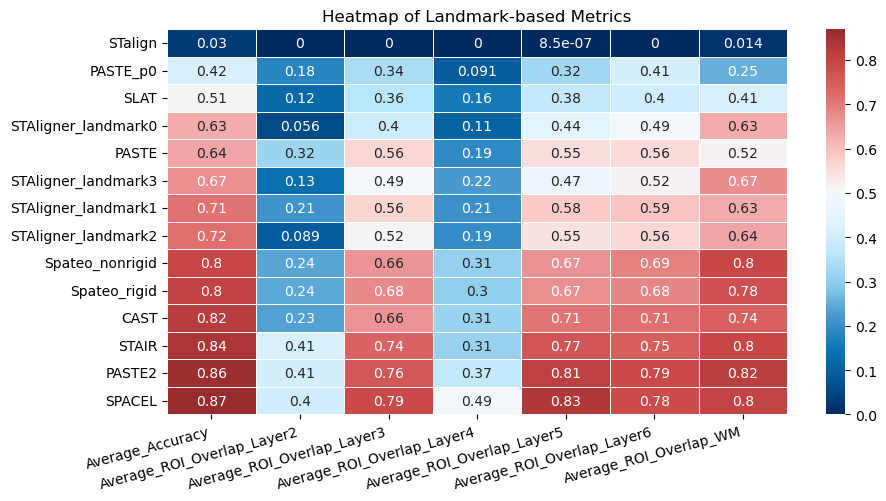

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

color_list =['#012A61','#015696','#0B75B3','#4596CD','#89CAEA','#BBE6FA','#E2F4FE','#F5F8FA', '#FCCDC9', '#EE9D9F', '#DE6A69', '#C84747','#982B2D']

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', color_list, N=256)

file_path = '/SABench/FeatureSimilarity/DLPFCS_LandmarkBased_Heatmap_PlotFig.csv'
data = pd.read_csv(file_path, index_col=0)
data = data.sort_values(by=data.columns[0])

plt.figure(figsize=(10, 5))
ax = sns.heatmap(data, annot=True, cmap=custom_cmap, linewidth=.5)
plt.xticks(rotation=15, ha='right')
plt.title('Heatmap of Landmark-based Metrics')
plt.show()